**Get glacier attributes from OGGM pipeline**

Download glacier attribute data using OGGM pipeline. Download data based on RGI-region or RGI-ids from point mass balance dataset.



In [26]:
# Import libraries

import xarray as xr
import numpy as np
import rioxarray
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm import entity_task, global_tasks
from oggm.utils import compile_climate_input
from oggm.core import gis
from oggm.utils import DEM_SOURCES
from pathlib import Path
import os
import logging
from datetime import datetime, timedelta

pd.set_option('display.max_columns',None)

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True 
cfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))


2023-05-24 11:09:52: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-05-24 11:09:52: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-05-24 11:09:52: oggm.cfg: Multiprocessing: using all available processors (N=4)
2023-05-24 11:09:52: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2023-05-24 11:09:52: oggm.cfg: Multiprocessing switched ON after user settings.
2023-05-24 11:09:52: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [27]:
# Workspace path is path to store OGGM data
parent_path = os.path.dirname(Path().resolve())
workspace_path = os.path.join(parent_path, '/home/jovyan/ML_MB_Norway_data/oggm_data')

cfg.PATHS['working_dir'] = workspace_path

In [28]:
# Convert datetimes to right format
def decimal_to_datetime(ds):
    datetimes = []
    for dec_year in ds.time.data:
        year = int(dec_year)
        rem = dec_year - year

        base = datetime(year, 1, 1)
        calendar_time = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
        datetimes.append(calendar_time)
        
    climate_ds['time'] = datetimes
        
    return climate_ds

In [29]:
"""Downloads the raw W5E5 climate data with a given resolution (daily by default). Returns an xarray Dataset. 

function get_raw_climate_data(gdir; temp_resolution="daily", climate="W5E5")
    MBsandbox.process_w5e5_data(gdir, climate_type=climate, temporal_resol=temp_resolution) 
    fpath = gdir.get_filepath("climate_historical", filesuffix="_daily_W5E5")
    climate = xr.open_dataset(fpath)
    return climate
"""

@entity_task(log)
def get_gridded_features(gdir):
    """Retrieves and processes gridded and climate data for a gdir in order to create the dataset
        to be fed to machine learning models.
    """
    # Retrieve gridded data
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        gridded_ds = ds.load()
    # Retrieve climate data
    with xr.open_dataset(gdir.get_filepath('climate_historical')) as ds:
        climate_ds = ds.load()
    
    #### Climate data ####
    # First we start by processing the climate data
    # Trim climate dataset to desired period of the Hugonnet et al. (2021) dataset
    climate_ds = climate_ds.sel(time=slice('2000-01-01','2019-12-01')) 
    
    # Now we downscale the climate data to the specific glacier 
    # Temperature
    temps_2D = np.empty((climate_ds.temp.data.size, gridded_ds.topo.data.shape[0], gridded_ds.topo.data.shape[1]))
    i = 0
    for temp in climate_ds.temp.data:
        temps_2D[i,:,:] = np.tile(temp,gridded_ds.topo.data.shape) + 6.0/1000.0*(gridded_ds.topo.data - climate_ds.ref_hgt.data)
        i=i+1
    
    PDD_2D = np.sum(np.where(temps_2D > 0.0, temps_2D, 0.0), axis=0)
    
    # Rain
    rain_period_2D = np.empty((climate_ds.prcp.data.size, gridded_ds.topo.data.shape[0], gridded_ds.topo.data.shape[1]))
    i = 0
    for prcp in climate_ds.prcp.data:
        rain_period_2D[i,:,:] = np.tile(prcp,gridded_ds.topo.data.shape) 
        i=i+1
    
    rain_2D = np.sum(rain_period_2D, axis=0)
    
        # Snow
    snow_2D = np.where(temps_2D < 0.0, rain_period_2D, 0.0)
        
    # Now we create a dictionary with the full dataset, including the previous climate data
    # and all the interesting gridded datasets 
    training_data = {'PDD_2D': PDD_2D,
                 'rain_2D': rain_2D,
                 'snow_2D': snow_2D,
                 'topo': gridded_ds.topo.data,
                 'aspect': gridded_ds.aspect.data,
                 'slope': gridded_ds.slope.data,
                 'dis_from_border': gridded_ds.dis_from_border.data,
                 'glacier_mask': gridded_ds.glacier_mask.data,
                 'millan_ice_thickness': gridded_ds.millan_ice_thickness.data,
                 'hugonnet_dhdt': gridded_ds.hugonnet_dhdt.data,
                 'ID': gdir.rgi_id
        }
    
    return training_data

In [30]:
#%% Initialize glacier directories for Scandinavia

rgi_region = '08' # Scandinavia
rgi_version = '6'
rgi_dir = utils.get_rgi_dir(version=rgi_version)
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)
# We use the directories with the shop data in it: "W5E5_w_data"
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/'

# Initialize directories for all glaciers in Scandinavia
#gdirs = workflow.init_glacier_directories(rgidf, from_prepro_level=3, prepro_base_url=base_url, prepro_border=10, reset=True, force=True)

#%% Get only glaciers in point mass balance dataset

# Specify filepaths and filenames.
filepath = '/home/jovyan/ML_MB_Norway_data/'
filename = 'stake_mb_norway_cleaned_ids_latlon.csv'

# Load data
point_data = pd.read_csv(filepath + filename)#, sep=';')
# Get list of RGI ids
rgi_id = point_data['RGIID'].unique().tolist()

# Initialize directories for glaciers in point mass balance dataset
gdirs = workflow.init_glacier_directories(rgi_id, from_prepro_level=3, prepro_base_url=base_url, prepro_border=10, reset=True, force=True)

2023-05-24 11:10:31: oggm.workflow: init_glacier_directories from prepro level 3 on 32 glaciers.
2023-05-24 11:10:31: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 32 glaciers


In [42]:
## Tested tasks
task_list = [
    tasks.gridded_attributes,
    tasks.gridded_mb_attributes,
    get_gridded_features
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs, print_log=False)

2023-05-24 11:35:54: oggm.workflow: Execute entity tasks [gridded_attributes] on 32 glaciers
2023-05-24 11:36:00: oggm.workflow: Execute entity tasks [gridded_mb_attributes] on 32 glaciers


In [43]:
#training_data = workflow.execute_entity_task(get_gridded_features, gdirs, print_log=False)

2023-05-24 11:37:04: oggm.workflow: Execute entity tasks [get_gridded_features] on 32 glaciers


In [44]:
for gdir in gdirs:
    if (gdir.name == 'Nigardsbreen'):
        break

In [45]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
## List all variables
ds

<xarray.Dataset>
Dimensions:                  (x: 108, y: 108)
Coordinates:
  * x                        (x) float32 -4.117e+03 -4.016e+03 ... 6.69e+03
  * y                        (y) float32 6.848e+06 6.848e+06 ... 6.837e+06
Data variables: (12/20)
    topo                     (y, x) float32 545.2 473.4 365.1 ... 716.0 623.4
    topo_smoothed            (y, x) float32 585.5 530.5 436.3 ... 667.4 612.1
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    aspect                   (y, x) float32 0.528 0.638 0.7656 ... 0.7515 0.706
    slope_factor             (y, x) float32 1.123 1.071 1.016 ... 1.192 1.238
    dis_from_border          (y, x) float32 9.213e+03 9.143e+03 ... 1.428e+03
    catchment_area           (y, x) float32 nan nan nan nan ... nan nan nan nan
    lin_mb_above_z           (y, x) float32 nan nan nan nan ... nan nan nan nan
    oggm_mb_above_z          (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=7.099 +k=0.9996 +x_0=0 +y_0=0...
    max_h_dem:      1970.0707
    min_h_dem:      88.412544
    max_h_glacier:  1939.6395
    min_h_glacier:  311.37354

In [31]:
#ds.glacier_mask.plot()


In [32]:
#ds.slope_factor.plot()

Load point mass balance data and get coordinates

In [17]:
import pyproj
from pyproj import Transformer
import salem

In [5]:
# Open dataframe with observations and coordinates

# Specify filepaths and filenames.
filepath = '/home/jovyan/ML_MB_Norway_data/'
filename = 'stake_mb_norway_cleaned_ids_latlon.csv'

# Load data
point_data = pd.read_csv(filepath + filename)#, sep=';')

# Get list of RGIIDs
rgi_id = point_data['RGIID'].unique().tolist()

point_data

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,altitude,utm_east,utm_north,balance_winter,balance_summer,balance_netto,dt_prev_year_min_date,dt_curr_year_max_date,dt_curr_year_min_date,stake_remark,flag_correction,approx_loc,approx_altitude,diff_north,diff_east,diff_altitude,diff_netto,lat,lon,lat_approx,lon_approx
0,RGI60-08.01258,G021737E70130N,54,34,529400,7780050,500,Nederst pÃ¥ bretunga,L10,L1012,471.0,529480,7780100,1.32,-6.24,-4.92,25.09.2012 00:00,14.05.2013 00:00,07.11.2013 00:00,NaN,netto,N,N,50,80,-29.0,0.000000e+00,70.125889,21.777016,70.125449,21.774891
1,RGI60-08.01258,G021737E70130N,54,34,529400,7780050,500,Nederst pÃ¥ bretunga,L10,L1013,439.0,529453,7780088,1.68,-4.35,-2.67,07.11.2013 00:00,09.05.2014 00:00,24.09.2014 00:00,NaN,NaN,N,N,38,53,-61.0,0.000000e+00,70.125784,21.776300,70.125449,21.774891
2,RGI60-08.01258,G021737E70130N,54,34,529400,7780050,500,Nederst pÃ¥ bretunga,L10,L1013,444.0,529438,7780082,0.76,-4.17,-3.41,24.09.2014 00:00,08.05.2015 00:00,23.09.2015 00:00,NaN,NaN,N,N,32,38,-56.0,0.000000e+00,70.125732,21.775903,70.125449,21.774891
3,RGI60-08.01258,G021737E70130N,54,34,529400,7780050,500,Nederst pÃ¥ bretunga,L10,L1013,444.0,529438,7780082,0.78,-4.37,-3.59,23.09.2015 00:00,23.05.2016 00:00,22.09.2016 00:00,SnÃ¸dyp ut fra stakemÃ¥lingene (0.65 m) virker...,netto,N,N,32,38,-56.0,0.000000e+00,70.125732,21.775903,70.125449,21.774891
4,RGI60-08.01258,G021737E70130N,54,34,529400,7780050,500,Nederst pÃ¥ bretunga,L10,L1016,468.0,529348,7780059,1.59,-4.05,-2.46,22.09.2016 00:00,25.04.2017 00:00,29.09.2017 00:00,Sondert snÃ¸dyp.,NaN,N,N,9,-52,-32.0,0.000000e+00,70.125536,21.773523,70.125449,21.774891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,RGI60-08.02969,G006362E59989N,3141,32,351800,6647500,1080,Nederst pÃ¥ bretunga,B15,B1509,1078.0,351790,6647480,1.50,-3.57,-2.07,01.10.2012 00:00,03.05.2012 00:00,12.10.2012 00:00,Kombinasjon med stake 15-12,NaN,N,N,-20,-10,-2.0,0.000000e+00,59.938030,6.347331,59.938213,6.347495
4042,RGI60-08.02969,G006362E59989N,3141,32,351800,6647500,1080,Nederst pÃ¥ bretunga,B15,B1509,1078.0,351787,6647465,1.14,-4.29,-3.15,12.10.2012 00:00,29.05.2013 00:00,24.09.2013 00:00,Endring av stakelengden fra 7. august til 24. ...,NaN,N,N,-35,-13,-2.0,4.440000e-16,59.937895,6.347288,59.938213,6.347495
4043,RGI60-08.02969,G006362E59989N,3141,32,351800,6647500,1080,Nederst pÃ¥ bretunga,B15,B1514,1079.0,351773,6647494,1.19,-3.80,-2.61,14.10.2014 00:00,22.04.2015 00:00,14.10.2015 00:00,"StakemÃ¥lt snÃ¸dyp var 3.0 m, mens to sonderin...",NaN,N,N,-6,-27,-1.0,0.000000e+00,59.938150,6.347017,59.938213,6.347495
4044,RGI60-08.02969,G006362E59989N,3141,32,351800,6647500,1080,Nederst pÃ¥ bretunga,B15,B1514,1078.0,351785,6647480,1.72,-4.38,-2.66,14.10.2015 00:00,28.04.2016 00:00,06.10.2016 00:00,Basert pÃ¥ sondert snÃ¸dyp.,NaN,N,N,-20,-15,-2.0,0.000000e+00,59.938029,6.347241,59.938213,6.347495


In [6]:
gdirs = workflow.init_glacier_directories(rgi_id)

2023-05-24 08:41:00: oggm.workflow: Execute entity tasks [GlacierDirectory] on 32 glaciers


In [7]:
for gdir in gdirs:
    if (gdir.name == 'Nigardsbreen'):
        break

In [8]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
# List all variables
ds

<xarray.Dataset>
Dimensions:                  (x: 108, y: 108)
Coordinates:
  * x                        (x) float32 -4.117e+03 -4.016e+03 ... 6.69e+03
  * y                        (y) float32 6.848e+06 6.848e+06 ... 6.837e+06
Data variables:
    topo                     (y, x) float32 545.2 473.4 365.1 ... 716.0 623.4
    topo_smoothed            (y, x) float32 585.5 530.5 436.3 ... 667.4 612.1
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    millan_ice_thickness     (y, x) float32 nan nan nan nan ... nan nan nan nan
    millan_v                 (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    millan_vx                (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    millan_vy                (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hugonnet_dhdt            (y, x) float32 -0.0005632 -9.848e-05 ... 0.004648
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=7.099 +k=0.9996 +x_0=0 +y_0=0...
    max_h_dem:      1970.0707
    min_h_dem:      88.412544
    max_h_glacier:  1939.6395
    min_h_glacier:  311.37354

In [20]:
#point_data.lon


In [18]:
# Get list of latitude and longitude for Nigardsbreen

#df_loc_rgiid = point_data.loc[point_data['RGIID']=='RGI60-08.01126',('lon','lat')]

#list_lon = df_loc_rgiid.lon.values.tolist()
#list_lat = df_loc_rgiid.lat.values.tolist()
#len(list_lon)

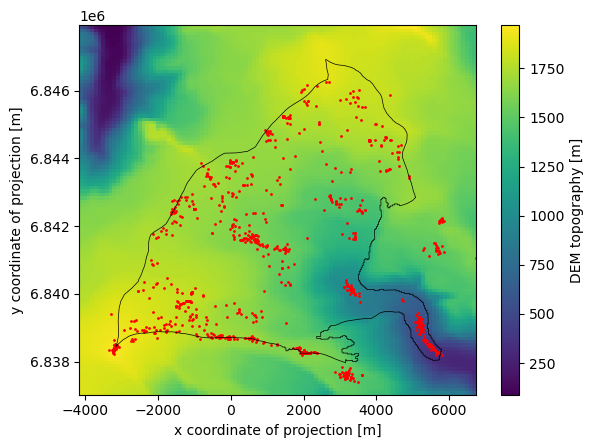

In [19]:
# Plot topography with stake locations for Nigardsbreen

df_loc_rgiid = point_data.loc[point_data['RGIID']=='RGI60-08.01126',('lon','lat')]

# lat, lon
list_lat = df_loc_rgiid.lat.values.tolist()
list_lon = df_loc_rgiid.lon.values.tolist()
#lat_stake = df_loc_rgiid.lat.unique()
#lon_stake = df_loc_rgiid.lon.unique()

transf = pyproj.Transformer.from_proj(salem.wgs84, gdir.grid.proj.srs, always_xy = True)

#for i in range(0,len(list_coords)):
x_stake, y_stake = transf.transform(list_lon, list_lat)
#y_stake

for gdir in gdirs:
    if (gdir.rgi_id == 'RGI60-08.01126'):
        break

with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

x_get = xr.DataArray(x_stake)
y_get = xr.DataArray(y_stake)  

from shapely.geometry import Polygon

shp = gdir.read_shapefile('outlines')
polygon = shp.geometry[0]
xp,yp = polygon.exterior.xy

f, ax = plt.subplots()
ds.topo.plot(ax=ax)
#ax.plot(polygon)
ax.plot(*polygon.exterior.xy, color='k',linewidth=0.5)

ax.scatter(x_stake,y_stake, s=1, color='r')
    
#stake = ds.sel(x = x_get, y = y_get, method='nearest')
#stake.aspect.plot()
#voi = ['aspect', 'slope', 'dis_from_border']
#stake_var = stake[voi]
#stake_var_df = stake_var.to_dataframe()
#stake_var
#df_loc_rgiid
#stake_var
#stake_var_df['x_stake'] = x_stake
#stake_var_df['y_stake'] = y_stake
#stake_var_df
#shp

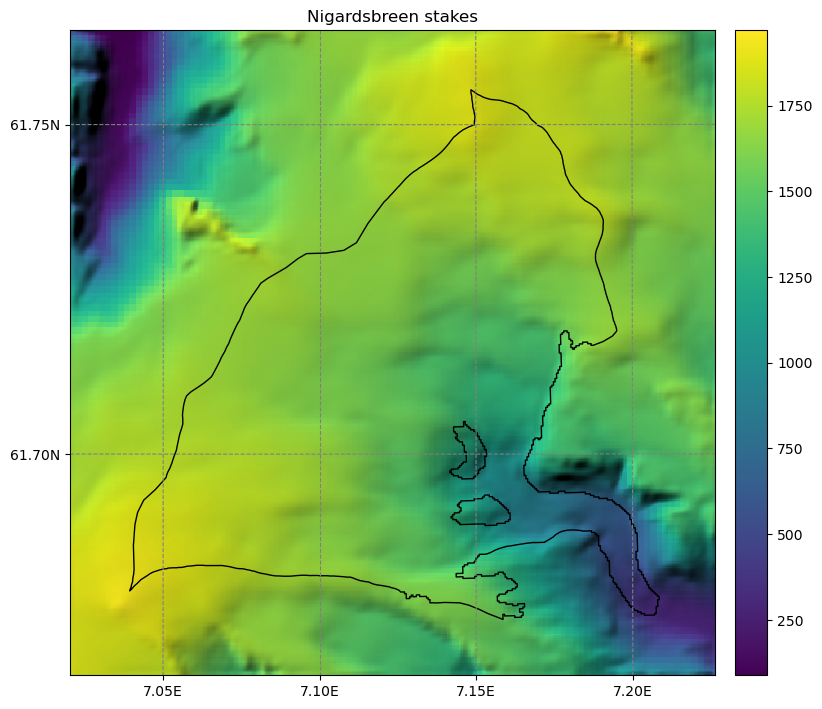

In [22]:
# Plot map of Nigardsbreen using salem. Does not work to add stake locations to this map.

smap = ds.salem.get_map(countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_topography(ds.topo.data);

# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))
smap.set_data(ds.topo.data)
#smap.set_cmap('RdBu')
#smap.set_plot_params(vmin=-3, vmax=3)
smap.visualize(ax=ax)
ax.scatter(x_stake,y_stake, s=64, color='r')#, zorder=0)

#smap.append_colorbar(ax=ax, label='elevation')

ax.set_title('Nigardsbreen stakes');
plt.show()

In [23]:
# Check coordinate projection of glacier directories

gdir.grid.proj.srs
from pyproj import CRS
crs = CRS.from_proj4(gdir.grid.proj.srs)
crs

<Projected CRS: +proj=tmerc +lat_0=0 +lon_0=7.099 +k=0.9996 +x_0=0 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Get glacier attributes based on lat/lon coordinates of stakes**

Get glacier attributes from downloaded OGGM data based on based on latitude and longitude of stake locations.


In [1]:
# Import libraries

import xarray as xr
import numpy as np
import rioxarray
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm import entity_task, global_tasks
from oggm.utils import compile_climate_input
from oggm.core import gis
from oggm.utils import DEM_SOURCES
from pathlib import Path
import os
import logging
from datetime import datetime, timedelta
import pyproj
from pyproj import Transformer
import salem

pd.set_option('display.max_columns',None)

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True 
cfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2023-05-28 06:59:03: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-05-28 06:59:03: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-05-28 06:59:03: oggm.cfg: Multiprocessing: using all available processors (N=4)
2023-05-28 06:59:04: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2023-05-28 06:59:04: oggm.cfg: Multiprocessing switched ON after user settings.
2023-05-28 06:59:04: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [2]:
# Set filepaths and load point data

# Filepath to store/retrieve data
filepath = '/home/jovyan/ML_MB_Norway_data/'

# Filename of point data with lat/lon coordinates
filename = 'stake_mb_norway_cleaned_ids_latlon.csv'

# Filename to store dataframe with attributes
filename_save = 'stake_mb_norway_cleaned_ids_latlon_wattributes.csv'

# Workspace path is path to store OGGM data
parent_path = os.path.dirname(Path().resolve())
workspace_path = os.path.join(parent_path, '/home/jovyan/ML_MB_Norway_data/oggm_data')
cfg.PATHS['working_dir'] = workspace_path

# Load data
point_data = pd.read_csv(filepath + filename)#, sep=';')

# Get list of RGIIDs
rgi_id = point_data['RGIID'].unique().tolist()

# Initialize glacier directories from list of RGIIDs
gdirs = workflow.init_glacier_directories(rgi_id)

#point_data
#gdirs

2023-05-28 06:59:15: oggm.workflow: Execute entity tasks [GlacierDirectory] on 32 glaciers


In [3]:
for gdir in gdirs:
    if (gdir.rgi_id == 'RGI60-08.01126'):
        break
        
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
    
ds

<xarray.Dataset>
Dimensions:                  (x: 108, y: 108)
Coordinates:
  * x                        (x) float32 -4.117e+03 -4.016e+03 ... 6.69e+03
  * y                        (y) float32 6.848e+06 6.848e+06 ... 6.837e+06
Data variables: (12/20)
    topo                     (y, x) float32 545.2 473.4 365.1 ... 716.0 623.4
    topo_smoothed            (y, x) float32 585.5 530.5 436.3 ... 667.4 612.1
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    aspect                   (y, x) float32 0.528 0.638 0.7656 ... 0.7515 0.706
    slope_factor             (y, x) float32 1.123 1.071 1.016 ... 1.192 1.238
    dis_from_border          (y, x) float32 9.213e+03 9.143e+03 ... 1.428e+03
    catchment_area           (y, x) float32 nan nan nan nan ... nan nan nan nan
    lin_mb_above_z           (y, x) float32 nan nan nan nan ... nan nan nan nan
    oggm_mb_above_z          (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=7.099 +k=0.9996 +x_0=0 +y_0=0...
    max_h_dem:      1970.0707
    min_h_dem:      88.412544
    max_h_glacier:  1939.6395
    min_h_glacier:  311.37354

In [4]:
df_stake = point_data.copy()

# Variables of interest
voi = ['topo','aspect', 'slope', 'slope_factor', 'dis_from_border']

# Add columns to dataframe
df_stake[voi] = np.nan
df_stake

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,altitude,utm_east,utm_north,balance_winter,balance_summer,balance_netto,dt_prev_year_min_date,dt_curr_year_max_date,dt_curr_year_min_date,stake_remark,flag_correction,approx_loc,approx_altitude,diff_north,diff_east,diff_altitude,diff_netto,lat,lon,lat_approx,lon_approx,topo,aspect,slope,slope_factor,dis_from_border
0,RGI60-08.01258,G021737E70130N,54,34,529400,7780050,500,Nederst pÃ¥ bretunga,L10,L1012,471.0,529480,7780100,1.32,-6.24,-4.92,25.09.2012 00:00,14.05.2013 00:00,07.11.2013 00:00,NaN,netto,N,N,50,80,-29.0,0.000000e+00,70.125889,21.777016,70.125449,21.774891,NaN,NaN,NaN,NaN,NaN
1,RGI60-08.01258,G021737E70130N,54,34,529400,7780050,500,Nederst pÃ¥ bretunga,L10,L1013,439.0,529453,7780088,1.68,-4.35,-2.67,07.11.2013 00:00,09.05.2014 00:00,24.09.2014 00:00,NaN,NaN,N,N,38,53,-61.0,0.000000e+00,70.125784,21.776300,70.125449,21.774891,NaN,NaN,NaN,NaN,NaN
2,RGI60-08.01258,G021737E70130N,54,34,529400,7780050,500,Nederst pÃ¥ bretunga,L10,L1013,444.0,529438,7780082,0.76,-4.17,-3.41,24.09.2014 00:00,08.05.2015 00:00,23.09.2015 00:00,NaN,NaN,N,N,32,38,-56.0,0.000000e+00,70.125732,21.775903,70.125449,21.774891,NaN,NaN,NaN,NaN,NaN
3,RGI60-08.01258,G021737E70130N,54,34,529400,7780050,500,Nederst pÃ¥ bretunga,L10,L1013,444.0,529438,7780082,0.78,-4.37,-3.59,23.09.2015 00:00,23.05.2016 00:00,22.09.2016 00:00,SnÃ¸dyp ut fra stakemÃ¥lingene (0.65 m) virker...,netto,N,N,32,38,-56.0,0.000000e+00,70.125732,21.775903,70.125449,21.774891,NaN,NaN,NaN,NaN,NaN
4,RGI60-08.01258,G021737E70130N,54,34,529400,7780050,500,Nederst pÃ¥ bretunga,L10,L1016,468.0,529348,7780059,1.59,-4.05,-2.46,22.09.2016 00:00,25.04.2017 00:00,29.09.2017 00:00,Sondert snÃ¸dyp.,NaN,N,N,9,-52,-32.0,0.000000e+00,70.125536,21.773523,70.125449,21.774891,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,RGI60-08.02969,G006362E59989N,3141,32,351800,6647500,1080,Nederst pÃ¥ bretunga,B15,B1509,1078.0,351790,6647480,1.50,-3.57,-2.07,01.10.2012 00:00,03.05.2012 00:00,12.10.2012 00:00,Kombinasjon med stake 15-12,NaN,N,N,-20,-10,-2.0,0.000000e+00,59.938030,6.347331,59.938213,6.347495,NaN,NaN,NaN,NaN,NaN
4042,RGI60-08.02969,G006362E59989N,3141,32,351800,6647500,1080,Nederst pÃ¥ bretunga,B15,B1509,1078.0,351787,6647465,1.14,-4.29,-3.15,12.10.2012 00:00,29.05.2013 00:00,24.09.2013 00:00,Endring av stakelengden fra 7. august til 24. ...,NaN,N,N,-35,-13,-2.0,4.440000e-16,59.937895,6.347288,59.938213,6.347495,NaN,NaN,NaN,NaN,NaN
4043,RGI60-08.02969,G006362E59989N,3141,32,351800,6647500,1080,Nederst pÃ¥ bretunga,B15,B1514,1079.0,351773,6647494,1.19,-3.80,-2.61,14.10.2014 00:00,22.04.2015 00:00,14.10.2015 00:00,"StakemÃ¥lt snÃ¸dyp var 3.0 m, mens to sonderin...",NaN,N,N,-6,-27,-1.0,0.000000e+00,59.938150,6.347017,59.938213,6.347495,NaN,NaN,NaN,NaN,NaN
4044,RGI60-08.02969,G006362E59989N,3141,32,351800,6647500,1080,Nederst pÃ¥ bretunga,B15,B1514,1078.0,351785,6647480,1.72,-4.38,-2.66,14.10.2015 00:00,28.04.2016 00:00,06.10.2016 00:00,Basert pÃ¥ sondert snÃ¸dyp.,NaN,N,N,-20,-15,-2.0,0.000000e+00,59.938029,6.347241,59.938213,6.347495,NaN,NaN,NaN,NaN,NaN


In [5]:
# For each RGIID get attributes in nearest stake locations
for i in rgi_id:
    
    # Get latitutde and longtidue of stake locations for the given glacier.
    df_loc_rgiid = point_data.loc[point_data['RGIID']==i,('lat','lon')]
    
    # Get lat/lon coordinates of each stake:
    lat_stake = df_loc_rgiid.lat.values#.unique()
    lon_stake = df_loc_rgiid.lon.values#.unique()
    
    for gdir in gdirs:
        if (gdir.rgi_id == i):
            break

    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()
       
    # Transform stake coordinates to OGGM data coordinates.
    transf = pyproj.Transformer.from_proj(salem.wgs84, gdir.grid.proj, always_xy = True)
    x_stake, y_stake = transf.transform(lon_stake, lat_stake)
    
    # Convert selected coordinates to DataArrays. 
    da_x_stake = xr.DataArray(x_stake, dims=['location'])
    da_y_stake = xr.DataArray(y_stake, dims=['location'])
    
    # Get glacier variables at these coordinates.
    stake = ds.sel(x = da_x_stake, y = da_y_stake, method='nearest')
    
    # Get dataset of variables of interest.
    stake_var = stake[voi]
    
    # Convert dataset to dataframe.
    stake_var_df = stake_var.to_pandas()

    # Insert values for given RGIID. Values should be sorted in the order of coordinates
    # (x_stake, y_stake) and (lon_stake, lat_stake).
    df_stake.loc[df_stake['RGIID']==i, voi] = stake_var_df[voi].values



In [6]:
# Check if nan values are left in voi columns.
df_stake.loc[df_stake['RGIID']==i, voi].isnull().values.any()

False

In [7]:
# Check altitude differences 
check_alt = df_stake['altitude']-df_stake['topo']

In [11]:
check_alt.loc[check_alt>100]

542     114.329102
722     186.807861
723     221.807861
724     256.807861
725     296.807861
751     106.807861
752     146.807861
1784    109.344971
2913    193.193970
2914    180.795105
2915    196.550659
2916    173.795105
2917    206.963684
2918    166.045349
2952    167.803284
2953    164.141052
2954    176.189209
2955    159.076599
2956    174.189209
2957    174.987671
2958    176.795105
2959    160.598999
2960    151.757935
2961    157.607666
2962    150.391785
2963    158.598999
2964    156.593140
2965    155.593140
dtype: float64

In [16]:
check_alt.loc[check_alt<-100]

856    -134.811462
1112   -300.296021
1373   -160.149902
1381   -105.226562
1475   -127.143677
1908   -143.237671
1909   -143.237671
1910   -151.237671
1911   -151.755493
1912   -162.755493
2126   -504.732666
2185   -580.388794
2707   -922.540405
dtype: float64

In [178]:
df_stake.loc[1112]

RGIID                          RGI60-08.02666
GLIMSID                        G005644E61747N
BREID                                    2078
utm_zone                                   32
utm_east_approx                        323850
utm_north_approx                      6851860
altitude_approx                           960
location_description     Nederst pÃ¥ bretunga
location_id                              AA12
stake_no                               AA1204
altitude                                647.0
utm_east                               323890
utm_north                             6851890
balance_winter                           3.72
balance_summer                          -4.66
balance_netto                           -0.95
dt_prev_year_min_date        12.10.2004 00:00
dt_curr_year_max_date        19.04.2005 00:00
dt_curr_year_min_date        16.10.2005 00:00
stake_remark                              NaN
flag_correction                           NaN
approx_loc                        

In [19]:
idx_check = check_alt.loc[check_alt<-100].index
idx_check = idx_check.union(check_alt.loc[check_alt>100].index)
idx_check


Index([ 542,  722,  723,  724,  725,  751,  752,  856, 1112, 1373, 1381, 1475,
       1784, 1908, 1909, 1910, 1911, 1912, 2126, 2185, 2707, 2913, 2914, 2915,
       2916, 2917, 2918, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960,
       2961, 2962, 2963, 2964, 2965],
      dtype='int64')

In [21]:
df_check = df_stake.loc[idx_check]
# Save dataframe with point data and glacier attributes
df_check.to_csv(filepath + 'check_data.csv')
df_check

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,altitude,utm_east,utm_north,balance_winter,balance_summer,balance_netto,dt_prev_year_min_date,dt_curr_year_max_date,dt_curr_year_min_date,stake_remark,flag_correction,approx_loc,approx_altitude,diff_north,diff_east,diff_altitude,diff_netto,lat,lon,lat_approx,lon_approx,topo,aspect,slope,slope_factor,dis_from_border
542,RGI60-08.01026,G017996E68104N,703,33,624600,7558350,1270,NaN,C9,C9,1377.0,624629,7558343,1.58,-2.07,-0.49,12.08.1966 00:00,19.05.1967 00:00,30.10.1967 00:00,NaN,NaN,N,N,-7,29,107.0,-2.220000e-16,68.111700,17.996646,68.111775,17.995958,1262.670898,0.205868,0.319061,1.984612,23.000000
722,RGI60-08.01657,G013853E66657N,1094,33,445600,7396700,300,Slett omrÃ¥de midt pÃ¥ bretunga ca 300 moh.,E17,E1070,440.0,445600,7396700,-0.77,-5.37,-6.14,15.09.1970 00:00,22.06.1971 00:00,08.09.1971 00:00,mÃ¥ledatoer,NaN,Y,N,0,0,140.0,8.880000e-16,66.684080,13.768262,66.684080,13.768262,253.192139,5.914623,0.314418,2.002147,282.000000
723,RGI60-08.01657,G013853E66657N,1094,33,445600,7396700,300,Slett omrÃ¥de midt pÃ¥ bretunga ca 300 moh.,E17,E1170,475.0,445600,7396700,-0.99,-5.36,-6.35,15.09.1970 00:00,22.06.1971 00:00,08.09.1971 00:00,mÃ¥ledatoer,NaN,Y,N,0,0,175.0,8.880000e-16,66.684080,13.768262,66.684080,13.768262,253.192139,5.914623,0.314418,2.002147,282.000000
724,RGI60-08.01657,G013853E66657N,1094,33,445600,7396700,300,Slett omrÃ¥de midt pÃ¥ bretunga ca 300 moh.,E17,E1270,510.0,445600,7396700,-0.87,-5.16,-6.03,15.09.1970 00:00,22.06.1971 00:00,08.09.1971 00:00,mÃ¥ledatoer,NaN,Y,N,0,0,210.0,0.000000e+00,66.684080,13.768262,66.684080,13.768262,253.192139,5.914623,0.314418,2.002147,282.000000
725,RGI60-08.01657,G013853E66657N,1094,33,445600,7396700,300,Slett omrÃ¥de midt pÃ¥ bretunga ca 300 moh.,E17,E1370,550.0,445600,7396700,-1.18,-6.28,-7.46,15.09.1970 00:00,22.06.1971 00:00,08.09.1971 00:00,mÃ¥ledatoer,netto,Y,N,0,0,250.0,0.000000e+00,66.684080,13.768262,66.684080,13.768262,253.192139,5.914623,0.314418,2.002147,282.000000
751,RGI60-08.01657,G013853E66657N,1094,33,445600,7396700,300,Slett omrÃ¥de midt pÃ¥ bretunga ca 300 moh.,E17,E870,360.0,445600,7396700,-1.10,-5.80,-6.90,15.09.1970 00:00,22.06.1971 00:00,08.09.1971 00:00,mÃ¥ledatoer,NaN,Y,N,0,0,60.0,0.000000e+00,66.684080,13.768262,66.684080,13.768262,253.192139,5.914623,0.314418,2.002147,282.000000
752,RGI60-08.01657,G013853E66657N,1094,33,445600,7396700,300,Slett omrÃ¥de midt pÃ¥ bretunga ca 300 moh.,E17,E970,400.0,445600,7396700,-0.82,-5.45,-6.27,15.09.1970 00:00,22.06.1971 00:00,08.09.1971 00:00,mÃ¥ledatoer,NaN,Y,N,0,0,100.0,8.880000e-16,66.684080,13.768262,66.684080,13.768262,253.192139,5.914623,0.314418,2.002147,282.000000
856,RGI60-08.01657,G013853E66657N,1094,33,445900,7395800,600,Lita flate i brefallet,E500,E40020,440.0,445900,7395800,-0.14,-7.42,-7.56,27.09.2019 00:00,10.06.2020 00:00,01.10.2020 00:00,mÃ¥ledatoar,NaN,Y,N,0,0,-160.0,0.000000e+00,66.676062,13.775452,66.676062,13.775452,574.811462,5.631855,0.193656,2.677824,338.921814
1112,RGI60-08.02666,G005644E61747N,2078,32,323850,6851860,960,Nederst pÃ¥ bretunga,AA12,AA1204,647.0,323890,6851890,3.72,-4.66,-0.95,12.10.2004 00:00,19.04.2005 00:00,16.10.2005 00:00,NaN,NaN,N,N,30,40,-313.0,-1.000000e-02,61.759332,5.662908,61.759045,5.662181,947.296021,0.417123,0.201504,2.614749,84.970581
1373,RGI60-08.02666,G005644E61747N,2078,32,323100,6850900,1240,NaN,AA28,AA2889Ned,1077.0,323100,6850900,3.35,-2.95,0.40,21.10.1988 00:00,16.04.1989 00:00,28.10.1989 00:00,Ble kalt 28Ned. Verdier tatt fra diagram.,NaN,Y,N,0,0,-163.0,1.110000e-16,61.750096,5.648934,61.750096,5.648934,1237.149902,0.513280,0.176293,2.833080,953.035156


Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-13:
Process ForkPoolWorker-14:
Traceback (most recent call last):
  File "/home/jovyan/envs/oggm_env/lib/python3.11/multiprocessing/managers.py", line 814, in _callmethod
    conn = self._tls.connection
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'ForkAwareLocal' object has no attribute 'connection'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jovyan/envs/oggm_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/jovyan/envs/oggm_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/jovyan/envs/oggm_env/lib/python3.11/multiprocessing/pool.py", line 109, in worker
    initializer(*

In [115]:
# Save dataframe with point data and glacier attributes
#df_stake.to_csv(filepath + filename_save)

**Example: Get glacier attributes for Nigardsbreen**

In [ ]:
# Import libraries

import xarray as xr
import numpy as np
import rioxarray
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm import entity_task, global_tasks
from oggm.utils import compile_climate_input
from oggm.core import gis
from oggm.utils import DEM_SOURCES
from pathlib import Path
import os
import logging
from datetime import datetime, timedelta
import pyproj
from pyproj import Transformer
import salem

pd.set_option('display.max_columns',None)

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True 
cfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

In [116]:
# Set filepaths and load point data

# Filepath to store/retrieve data
filepath = '/home/jovyan/ML_MB_Norway_data/'

# Filename of point data with lat/lon coordinates
filename = 'stake_mb_norway_cleaned_ids_latlon.csv'

# Workspace path is path to store OGGM data
parent_path = os.path.dirname(Path().resolve())
workspace_path = os.path.join(parent_path, '/home/jovyan/ML_MB_Norway_data/oggm_data')
cfg.PATHS['working_dir'] = workspace_path

# Load data
point_data = pd.read_csv(filepath + filename)#, sep=';')

# List of RGIIDs with only Nigardsbreen
rgi_id = ['RGI60-08.01126']

# Initialize glacier directories from list of RGIIDs
gdirs = workflow.init_glacier_directories(rgi_id)

for gdir in gdirs:
    if (gdir.rgi_id == 'RGI60-08.01126'):
        break
        
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()  
ds

2023-05-27 15:02:33: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


<xarray.Dataset>
Dimensions:                  (x: 108, y: 108)
Coordinates:
  * x                        (x) float32 -4.117e+03 -4.016e+03 ... 6.69e+03
  * y                        (y) float32 6.848e+06 6.848e+06 ... 6.837e+06
Data variables: (12/20)
    topo                     (y, x) float32 545.2 473.4 365.1 ... 716.0 623.4
    topo_smoothed            (y, x) float32 585.5 530.5 436.3 ... 667.4 612.1
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    aspect                   (y, x) float32 0.528 0.638 0.7656 ... 0.7515 0.706
    slope_factor             (y, x) float32 1.123 1.071 1.016 ... 1.192 1.238
    dis_from_border          (y, x) float32 9.213e+03 9.143e+03 ... 1.428e+03
    catchment_area           (y, x) float32 nan nan nan nan ... nan nan nan nan
    lin_mb_above_z           (y, x) float32 nan nan nan nan ... nan nan nan nan
    oggm_mb_above_z          (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=7.099 +k=0.9996 +x_0=0 +y_0=0...
    max_h_dem:      1970.0707
    min_h_dem:      88.412544
    max_h_glacier:  1939.6395
    min_h_glacier:  311.37354

In [123]:
# Get stake data for Nigardsbreen
df_stake = point_data.loc[point_data['RGIID']==i].copy()

# Variables of interest
voi = ['topo','aspect', 'slope', 'slope_factor', 'dis_from_border']

# Add columns to dataframe
df_stake[voi] = np.nan
df_stake

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,altitude,utm_east,utm_north,balance_winter,balance_summer,balance_netto,dt_prev_year_min_date,dt_curr_year_max_date,dt_curr_year_min_date,stake_remark,flag_correction,approx_loc,approx_altitude,diff_north,diff_east,diff_altitude,diff_netto,lat,lon,lat_approx,lon_approx,topo,aspect,slope,slope_factor,dis_from_border
1930,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N1000,974.0,402758,6841501,1.53,-5.64,-4.11,19.10.1990 00:00,02.05.1991 00:00,28.09.1991 00:00,bv er basert pÃ¥ sondering,NaN,N,N,1,8,-16.0,-8.880000e-16,61.694315,7.161649,61.694304,7.161498,NaN,NaN,NaN,NaN,NaN
1931,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N1000,1000.0,402750,6841500,1.12,-5.08,-3.96,26.09.1997 00:00,12.05.1998 00:00,22.09.1998 00:00,NaN,NaN,Y,N,0,0,10.0,0.000000e+00,61.694304,7.161498,61.694304,7.161498,NaN,NaN,NaN,NaN,NaN
1932,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N1000,1019.0,402620,6841793,2.12,-5.82,-3.70,30.09.1999 00:00,04.05.2000 00:00,13.09.2000 00:00,Det ble pÃ¥vist smelting etter minimumsmÃ¥ling...,NaN,N,N,293,-130,29.0,0.000000e+00,61.696900,7.158885,61.694304,7.161498,NaN,NaN,NaN,NaN,NaN
1933,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N100000,974.0,402741,6841525,0.87,-5.35,-4.48,13.09.2000 00:00,05.05.2001 00:00,19.09.2001 00:00,Smeltingen er estimert fra mai til august.,NaN,N,N,25,-9,-16.0,-8.880000e-16,61.694526,7.161315,61.694304,7.161498,NaN,NaN,NaN,NaN,NaN
1934,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N100002,962.0,402810,6841420,1.07,-6.07,-5.00,19.09.2001 00:00,06.05.2002 00:00,07.10.2002 00:00,Delvis estimert,NaN,N,N,-80,60,-28.0,0.000000e+00,61.693602,7.162674,61.694304,7.161498,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2877,RGI60-08.01126,G007099E61715N,2297,32,401670,6847020,1800,NaN,N99,N9968,1802.0,401669,6847025,2.04,-1.25,0.79,22.10.1969 00:00,08.04.1970 00:00,02.09.1970 00:00,NaN,NaN,N,N,5,-1,2.0,0.000000e+00,61.743600,7.138086,61.743556,7.138108,NaN,NaN,NaN,NaN,NaN
2878,RGI60-08.01126,G007099E61715N,2297,32,400520,6842250,1555,NaN,NaN,NA63,1555.0,400520,6842250,0.91,-0.80,0.11,20.09.1962 00:00,17.05.1963 00:00,01.10.1963 00:00,Dato for minimumsmÃ¥ling er ukjent.,NaN,N,N,0,0,0.0,1.390000e-17,61.700462,7.118957,61.700462,7.118957,NaN,NaN,NaN,NaN,NaN
2879,RGI60-08.01126,G007099E61715N,2297,32,400350,6842570,1579,NaN,NC,NC63,1579.0,400350,6842570,1.30,-1.16,0.14,20.09.1962 00:00,17.05.1963 00:00,01.10.1963 00:00,Dato for minimumsmÃ¥ling 1963 er ukjent.,NaN,N,N,0,0,0.0,-1.110000e-16,61.703289,7.115569,61.703289,7.115569,NaN,NaN,NaN,NaN,NaN
2880,RGI60-08.01126,G007099E61715N,2297,32,400260,6840930,1612,NaN,NF,NF62,1579.0,400370,6841520,2.76,0.04,2.80,NaN,13.05.2962 00:00,20.09.1962 00:00,I 1962 ble staken kalt 22,NaN,N,N,590,110,-33.0,0.000000e+00,61.693873,7.116522,61.688551,7.114767,NaN,NaN,NaN,NaN,NaN


In [124]:
# For each RGIID get attributes in nearest stake locations
for i in rgi_id:
    
    # Get latitutde and longtidue of stake locations for the given glacier.
    df_loc_rgiid = point_data.loc[point_data['RGIID']==i,('lat','lon')]
    
    # Get lat/lon coordinates of each stake:
    lat_stake = df_loc_rgiid.lat.values#.unique()
    lon_stake = df_loc_rgiid.lon.values#.unique()
    
    for gdir in gdirs:
        if (gdir.rgi_id == i):
            break

    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()
       
    # Transform stake coordinates to OGGM data coordinates.
    transf = pyproj.Transformer.from_proj(salem.wgs84, gdir.grid.proj, always_xy = True)
    x_stake, y_stake = transf.transform(lon_stake, lat_stake)
    
    # Convert selected coordinates to DataArrays. 
    da_x_stake = xr.DataArray(x_stake, dims=['location'])
    da_y_stake = xr.DataArray(y_stake, dims=['location'])
    
    # Get glacier variables at these coordinates.
    stake = ds.sel(x = da_x_stake, y = da_y_stake, method='nearest')
    
    # Get dataset of variables of interest.
    stake_var = stake[voi]
    
    # Convert dataset to dataframe.
    stake_var_df = stake_var.to_pandas()

    # Insert values for given RGIID. Values should be sorted in the order of coordinates
    # (x_stake, y_stake) and (lon_stake, lat_stake).
    df_stake.loc[df_stake['RGIID']==i, voi] = stake_var_df[voi].values

In [131]:
df_stake[0:10]

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,altitude,utm_east,utm_north,balance_winter,balance_summer,balance_netto,dt_prev_year_min_date,dt_curr_year_max_date,dt_curr_year_min_date,stake_remark,flag_correction,approx_loc,approx_altitude,diff_north,diff_east,diff_altitude,diff_netto,lat,lon,lat_approx,lon_approx,topo,aspect,slope,slope_factor,dis_from_border
1930,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N1000,974.0,402758,6841501,1.53,-5.64,-4.11,19.10.1990 00:00,02.05.1991 00:00,28.09.1991 00:00,bv er basert pÃ¥ sondering,NaN,N,N,1,8,-16.0,-8.880000e-16,61.694315,7.161649,61.694304,7.161498,959.006470,2.465503,0.152608,3.089254,285.671143
1931,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N1000,1000.0,402750,6841500,1.12,-5.08,-3.96,26.09.1997 00:00,12.05.1998 00:00,22.09.1998 00:00,NaN,NaN,Y,N,0,0,10.0,0.000000e+00,61.694304,7.161498,61.694304,7.161498,968.290161,2.333727,0.143458,3.206009,225.842865
1932,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N1000,1019.0,402620,6841793,2.12,-5.82,-3.70,30.09.1999 00:00,04.05.2000 00:00,13.09.2000 00:00,Det ble pÃ¥vist smelting etter minimumsmÃ¥ling...,NaN,N,N,293,-130,29.0,0.000000e+00,61.696900,7.158885,61.694304,7.161498,1008.026794,2.962544,0.131003,3.385560,303.000000
1933,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N100000,974.0,402741,6841525,0.87,-5.35,-4.48,13.09.2000 00:00,05.05.2001 00:00,19.09.2001 00:00,Smeltingen er estimert fra mai til august.,NaN,N,N,25,-9,-16.0,-8.880000e-16,61.694526,7.161315,61.694304,7.161498,968.290161,2.333727,0.143458,3.206009,225.842865
1934,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N100002,962.0,402810,6841420,1.07,-6.07,-5.00,19.09.2001 00:00,06.05.2002 00:00,07.10.2002 00:00,Delvis estimert,NaN,N,N,-80,60,-28.0,0.000000e+00,61.693602,7.162674,61.694304,7.161498,950.410583,2.401391,0.163659,2.962348,225.842865
1935,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N100002,985.0,402650,6841485,0.77,-3.15,-2.39,07.10.2002 00:00,01.06.2003 00:00,20.09.2003 00:00,NaN,NaN,N,N,-15,-100,-5.0,-1.000000e-02,61.694144,7.159617,61.694304,7.161498,968.290161,2.333727,0.143458,3.206009,225.842865
1936,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N100002,985.0,402650,6841485,0.55,-5.50,-4.95,20.09.2003 00:00,11.05.2004 00:00,29.09.2004 00:00,NaN,NaN,N,N,-15,-100,-5.0,0.000000e+00,61.694144,7.159617,61.694304,7.161498,968.290161,2.333727,0.143458,3.206009,225.842865
1937,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N100005,1008.0,402614,6841737,1.92,-4.58,-2.66,29.09.2004 00:00,12.05.2005 00:00,16.10.2005 00:00,NaN,NaN,N,N,237,-136,18.0,0.000000e+00,61.696396,7.158802,61.694304,7.161498,1008.026794,2.962544,0.131003,3.385560,303.000000
1938,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N100005,978.0,402709,6841487,0.91,-7.21,-6.30,17.10.2005 00:00,06.05.2006 00:00,11.10.2006 00:00,NaN,NaN,N,N,-13,-41,-12.0,0.000000e+00,61.694177,7.160730,61.694304,7.161498,968.290161,2.333727,0.143458,3.206009,225.842865
1939,RGI60-08.01126,G007099E61715N,2297,32,402750,6841500,990,NaN,N1000,N100005,950.0,402867,6841362,0.74,-4.38,-3.65,11.10.2006 00:00,04.06.2007 00:00,27.09.2007 00:00,NaN,NaN,N,N,-138,117,-40.0,-1.000000e-02,61.693096,7.163782,61.694304,7.161498,939.746399,2.367803,0.175528,2.840483,285.671143


In [127]:
x_stake[0:10]

array([3314.20053976, 3306.23408509, 3167.74710114, 3296.50881127,
       3368.5380332 , 3206.72643011, 3206.72643011, 3163.38594036,
       3265.63600589, 3427.20107309])

In [128]:
y_stake[0:10]


array([6840128.93670199, 6840127.70359484, 6840416.74776973,
       6840152.42717848, 6840049.49934658, 6840109.79111576,
       6840109.79111576, 6840360.60292269, 6840113.51319358,
       6839993.19553078])

In [129]:
lat_stake[0:10]


array([61.6943154 , 61.6943044 , 61.69690031, 61.69452643, 61.69360182,
       61.69414445, 61.69414445, 61.69639634, 61.69417736, 61.69309587])

In [130]:
lon_stake[0:10]

array([7.16164876, 7.16149814, 7.15888534, 7.16131475, 7.16267443,
       7.15961682, 7.15961682, 7.15880191, 7.16073046, 7.16378226])

In [133]:
check_alt = df_stake['altitude']-df_stake['topo']

In [136]:
check_alt.min()

-922.5404052734375

In [137]:
df_stake['topo'].max()

1952.8284912109375

In [138]:
df_stake['topo'].min()

317.0606689453125

In [139]:
df_stake['altitude'].min()

314.0

In [140]:
df_stake['altitude'].max()

1984.0

In [147]:
check_alt.idxmin()

2707

In [149]:
df_stake.loc[2707]

RGIID                                              RGI60-08.01126
GLIMSID                                            G007099E61715N
BREID                                                        2297
utm_zone                                                       32
utm_east_approx                                            404165
utm_north_approx                                          6841115
altitude_approx                                               728
location_description                                          NaN
location_id                                                    N9
stake_no                                                     N964
altitude                                                    728.0
utm_east                                                   404165
utm_north                                                 6845115
balance_winter                                               0.49
balance_summer                                              -6.86
balance_ne

In [150]:
check_alt

1930    14.993530
1931    31.709839
1932    10.973206
1933     5.709839
1934    11.589417
          ...    
2877     3.546509
2878    -2.066162
2879    -7.412109
2880     8.545654
2881     0.959839
Length: 952, dtype: float64

In [158]:
check_alt.loc[check_alt<-100]

2126   -504.732666
2185   -580.388794
2707   -922.540405
dtype: float64

In [161]:
df_stake.loc[2126]

RGIID                      RGI60-08.01126
GLIMSID                    G007099E61715N
BREID                                2297
utm_zone                               32
utm_east_approx                    402550
utm_north_approx                  6839000
altitude_approx                      1515
location_description                  NaN
location_id                           N50
stake_no                            N5082
altitude                            998.0
utm_east                           402550
utm_north                         6839000
balance_winter                        NaN
balance_summer                      -6.32
balance_netto                         NaN
dt_prev_year_min_date    14.10.1981 00:00
dt_curr_year_max_date    13.05.1982 00:00
dt_curr_year_min_date    24.10.1982 00:00
stake_remark                          NaN
flag_correction                       NaN
approx_loc                              Y
approx_altitude                         N
diff_north                        

In [162]:
df_stake.loc[2185]

RGIID                                   RGI60-08.01126
GLIMSID                                 G007099E61715N
BREID                                             2297
utm_zone                                            32
utm_east_approx                                 401450
utm_north_approx                               6839700
altitude_approx                                   1630
location_description                   Ved Steinmannen
location_id                                        N51
stake_no                                         N5182
altitude                                        1038.0
utm_east                                        401450
utm_north                                      6839700
balance_winter                                     NaN
balance_summer                                   -6.26
balance_netto                                      NaN
dt_prev_year_min_date                 14.10.1981 00:00
dt_curr_year_max_date                 13.05.1982 00:00
dt_curr_ye